# Nonlin_vector-valued


In [128]:
%pylab inline
import scipy

from pyiga import bspline, assemble, geometry, solvers, vis

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\MHeig\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['grid', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [129]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

def linelast_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx
    vf = VForm(dim)
    u, v = vf.basisfuns(components=(dim,dim)) # vector valued
    #vf.add(2* Mu *inner(1/2 * (grad(u) + grad(u).T), 1/2 * (grad(v) + grad(v).T)) * dx + Lam * div(u) * div(v)  * dx)
    e_u = 1/2 * (grad(u) + grad(u).T)
    e_v =  1/2 * (grad(v) + grad(v).T)
    vf.add(2* Mu *inner(e_u, e_v) * dx + Lam * div(u) * div(v)  * dx) 
    return vf


In [130]:
# define geometry
geo = geometry.quarter_annulus()

# define discretization space
p =3  # spline degree of velocity space #p=3
#n_el = (50, 20)   # number of elements in y/x direction
n_el = (5, 10) # istotropic material

# displacement space: degree p,   continuity p-2
kvs_u = tuple(bspline.make_knots(p,  0.0, 1.0, n, mult=1) for n in n_el)
m_u = tuple(kv.numdofs for kv in kvs_u)
N = np.prod(tuple(kv.numdofs for kv in kvs_u))

A = assemble.assemble_vf(linelast_vf(2), kvs_u, geo=geo, symmetric=True)
print(shape(A))

(208, 208)


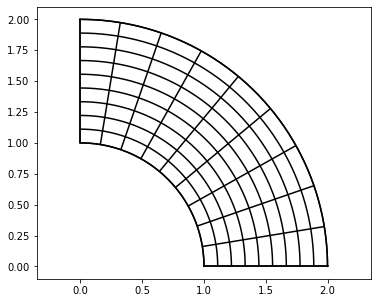

In [131]:
# undeformed quater annulus
figsize(6,5)
vis.plot_geo(geo, grid=2)

grid = geometry.outer_product(geometry.circular_arc(pi/2), geometry.line_segment(1, 2))
vis.plot_geo(grid)
axis('equal');

In [132]:
# define Dirichlet boundary conditions
def g_zero(x, y): return (0.0, 0.0)

# set Dirichlet condition
bcs = assemble.compute_dirichlet_bcs(kvs_u, geo,
        [('left', g_zero)]) # left: dirichlet boundary cond.


In [133]:
# set inhom. Neumann cond. on distal end, hom. NBC elsewhere

#Neumann BC
def gN(x, y): return (1.5e-4, -1.5e-4) 


# assemble neumann condition
gn= assemble.assemble('inner(g,v)*ds', kvs_u, bfuns=[('v',2)], geo=geo, g=gN, boundary='top')
bd_dofs= assemble.boundary_dofs(kvs_u,'top',ravel=True) # gives us all boundary dofs

# incorporate neumnann boundary condition
shape_a= shape(A)[0]

nbc= np.zeros(shape(A)[0])
for i in range(len(bd_dofs)):
    nbc[bd_dofs[i]]= gn[0,0,i] #gn[0,0,i] X-component
    nbc[bd_dofs[i]+shape_a//2]= gn[1,0,i] #gn[1,0,i] Y component
print(shape(nbc))

(208,)


In [134]:
f = lambda x,y: (0,0)  # source term
rhs = assemble.inner_products(kvs_u, f, f_physical=True, geo=geo).ravel()
print(shape(rhs))
#print(rhs)

(208,)


In [135]:
###########################
# solve Linear Elasticity Problem (for inital value)
# solve system with the given boundary conditions and 0 right-hand side
#LS = assemble.RestrictedLinearSystem(A, rhs+nbc, bcs)
#u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
#u = LS.complete(u)

In [136]:
#split the solution into its components (displacement in x- and y- direction)
def get_components(u):
    """Split solution vector into displacement components."""
    u1 = u[:N].reshape(m_u)
    u2 = u[N:2*N].reshape(m_u)
    U = np.stack((u1,u2), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)


In [137]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

def elast_lin_vf(dim, dis):
    from pyiga.vform import VForm, grad, inner, div, tr, dx
    vf = VForm(dim)
    u, v = vf.basisfuns(components=(dim,dim)) # vector valued
    l_term1 = div(dis)*grad(u)+ 1/2 *tr( grad(dis).T*grad(dis)) * grad(u)
    l_term2 = div(u)*np.identity(dim) + tr(grad(dis).T*grad(u))*np.identity(dim)
    l_term3 = div(u)*grad(dis) + tr(grad(dis).T*grad(u))*grad(dis)
    
    m_term1 = grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T*grad(dis))
    m_term2= ( grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis))
    m_term3 = ( grad(dis)*grad(u)+ grad(dis)*grad(u).T + grad(dis)*grad(dis).T * grad(u) + grad(dis)*grad(u).T*grad(dis))
    
    
    vf.add(Lam* inner((l_term1 +l_term2 +l_term3), grad(v)) + Mu*inner((m_term1 +m_term2+m_term3), grad(v)) * dx) 
    return vf


def elast_nl_vf(dim, dis):
    from pyiga.vform import VForm, grad, inner, div, tr, dx
    vf = VForm(dim)
    u, v = vf.basisfuns(components=(dim,dim)) # vector valued
    l_term1 = div(dis)*tr(grad(v))+ 1/2 *tr(grad(dis).T * grad(dis))*tr(grad(v))
    l_term2 = inner(div(dis)*grad(dis), grad(v))
    l_term3 = inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v))
    
    m_term1 = inner(grad(dis).T +grad(dis) + grad(dis).T*grad(dis), grad(v))
    m_term2= inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v))
    
    vf.add(Lam * (l_term1 +l_term2 +l_term3)  + Mu * (m_term1 + m_term2) * dx) 
    return vf


def apply_nl_vf(u):
    dis = get_components(u)
    z = assemble.assemble_vf(elast_nl_vf(2, dis), kvs_u, bfuns=[('v',2)], geo=geo, dis=dis)
    return z.ravel() # vector z

def linearized_vf(u):
    dis = get_components(u)
    A_lin = assemble.assemble_vf(elast_lin_vf(2, dis), kvs_u, bfuns=[('u',2), ('v',2)], geo=geo, dis=dis) #matrix A
    return A_lin

In [138]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

def apply_nl(u):
    dis = get_components(u)
    z_lam = Lam* assemble.assemble('(div(dis)*tr(grad(v))+ 1/2 *tr( grad(dis).T *grad(dis)) *tr(grad(v)) + inner(div(dis)*grad(dis), grad(v)) + inner(1/2 * tr(grad(dis).T *grad(dis))*grad(dis), grad(v))) *dx'
                             , kvs_u, bfuns=[('v',2)], geo=geo, dis=dis)
    z_mu = Mu* assemble.assemble('(inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v)) + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v))) *dx'
                                    , kvs_u, bfuns=[('v',2)], geo=geo, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

def linearized(u):
    dis = get_components(u)
    A_lin_lam = Lam* assemble.assemble('inner((div(dis)*grad(u)+ 1/2 *tr( grad(dis).T *grad(dis)) * grad(u) + div(u)*grad(dis) + tr(grad(dis).T*grad(u)) * grad(dis)), grad(v)) + div(u)*tr(grad(v)) + tr(grad(dis).T*grad(u)) * tr(grad(v)) * dx'
                              , kvs_u, bfuns=[('u',2), ('v',2)], geo=geo, dis=dis) #matrix A
    
    A_lin_mu = Mu * assemble.assemble('inner((grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis))+ ( grad(u)+grad(u).T +grad(dis).T * grad(u)+ grad(u).T * grad(dis)) + ( grad(dis)*grad(u)+ grad(dis)*grad(u).T + grad(dis)*grad(dis).T * grad(u) + grad(dis)*grad(u).T*grad(dis)) ),grad(v)) * dx'
                              , kvs_u, bfuns=[('u',2), ('v',2)], geo=geo, dis=dis) #matrix A
    return A_lin_lam +A_lin_mu

In [139]:
dd = shape(rhs)[0]

In [140]:
ref = 10
# evaluate displacement and "pressure" over a grid in the parameter domain
xgrid = linspace(0, 1, ref)
xygrid = (xgrid, xgrid)

In [141]:
# solve linearized system 
### first iteration ###
#initial value
u= np.zeros(dd)

LS = assemble.RestrictedLinearSystem(linearized(u), nbc+rhs -apply_nl(u), bcs)   # rhs = 0 + 'old' a(u,v) # -apply_nl(u)
u_d= solvers.make_solver(LS.A).dot(LS.b)
u_d = LS.complete(u_d)
u+=u_d
# norm of delta u in first step
normed_du0= np.linalg.norm(u_d)
print(normed_du0)
#print(u)

0.18795764698311324


2
norm(delta_u) =  0.003635035345326503
step size u_d =  0.18432261163778674
3
norm(delta_u) =  0.002956809517983727
step size u_d =  0.0006782258273427761
4
norm(delta_u) =  0.0028414648833039262
step size u_d =  0.00011534463467980077
5
norm(delta_u) =  0.002731635422602745
step size u_d =  0.00010982946070118129
6
norm(delta_u) =  0.0026314122536198917
step size u_d =  0.0001002231689828533
7
norm(delta_u) =  0.002537422997715986
step size u_d =  9.398925590390576e-05
[ 0.00000000e+00 -3.25418310e-04 -1.86410011e-03 -2.51969629e-03
 -3.01670787e-03 -3.17088061e-03 -3.24906624e-03 -3.26071192e-03
 -3.24012588e-03 -3.23634610e-03 -3.24568279e-03 -3.26567106e-03
 -3.26741459e-03  0.00000000e+00  2.45796883e-05  1.17204045e-04
 -1.55952443e-04 -4.12569720e-04 -5.75021457e-04 -6.50728565e-04
 -6.38310213e-04 -5.61600934e-04 -4.14460214e-04 -2.15908617e-04
 -6.56321303e-05 -2.07703638e-05  0.00000000e+00  1.86291265e-04
  6.28757999e-04  1.40538403e-03  2.17265615e-03  2.88626948e-03
  3.

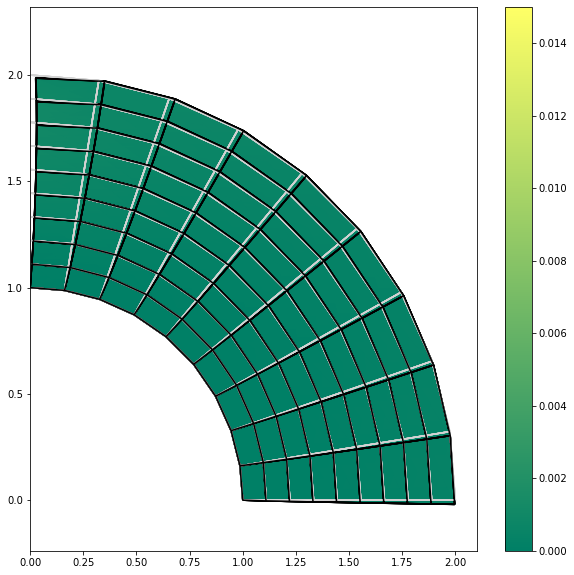

In [142]:
# solve linearized variational problem
epsilon= 1e-4
count= 1

figsize(10,10)
fig, ax = plt.subplots()

stepsizes =[]

while True:
    count+=1
    print(count)

     # B-spline function, takes coeff u
    LS = assemble.RestrictedLinearSystem(linearized(u), nbc+rhs-apply_nl(u), bcs)   # rhs = 0 + 'old' a(u,v)
    u_d = solvers.make_solver(LS.A).dot(LS.b)
    u_d = LS.complete(u_d) # value
    
    #update (u= u+ delta_u)
    u+= u_d
    
    normed_du = np.linalg.norm(u_d)
    stepsize_du = abs(normed_du0-normed_du)
    print('norm(delta_u) = ', normed_du)
    print ('step size u_d = ', stepsize_du)
    
    stepsizes.append(stepsize_du)

    displ = get_components(u).grid_eval(xygrid)
    vis.plot_deformation(displ, ref, geo, ax, vmin=0.0, vmax=1.5e-2)
    #steps= np.append(steps,[u_d])

    
    if abs(normed_du0-normed_du) < epsilon:
        break
    elif count == 55:
        break
        
    normed_du0 = normed_du

print(u)
colorbar();
axis('equal');

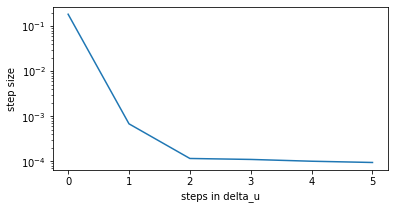

In [143]:
# plot history of step sizes
figsize(6,3)
yscale('log')
plot(stepsizes);
xlabel('steps in delta_u'); ylabel('step size');